# IMPORTS
This block imports all essential libraries for data handling, image preprocessing, model building, and training using PyTorch and torchvision.

In [1]:
# Pacchetti base
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Subset, Dataset

# Utilità
from sklearn.model_selection import StratifiedShuffleSplit
from PIL import Image
from tqdm.notebook import tqdm


# GLOBALS
This section sets the random seed for reproducibility, selects the computing device (GPU or CPU), defines dataset paths, and sets key training parameters like batch size, learning rate, and number of epochs.

In [12]:
# Riproducibilità
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Path dataset
dataset_root = "/kaggle/input/food101/food-101"
images_root = os.path.join(dataset_root, "images")
train_txt = os.path.join(dataset_root, "meta", "train.txt")
test_txt  = os.path.join(dataset_root, "meta", "test.txt")

# Batch size
batch_size = 64

# Iperparametri
LR_ID_INIT = 2e-4
WEIGHT_DECAY = 1e-4
EPOCHS_ID = 20


Using device: cuda


# UTILS
This block defines all the key functions for splitting your dataset and calculating OOD detection scores. First, it implements load_indices(...), which reads file paths from .txt files and matches them to your dataset to construct precise training and testing subsets. Then, it defines two score functions decorated with @torch.no_grad() to disable gradient tracking — one computing *energy scores* via log‑sum‑exp over model logits, and the other computing *Maximum Softmax Probability (MSP)* to estimate model confidence. Together, these components streamline dataset splitting and enable efficient scoring for out‑of‑distribution evaluation.

In [3]:
# Carica indici da file .txt
def load_indices(txt_file, dataset):
    with open(txt_file, "r") as f:
        lines = f.read().splitlines()
    idxs = []
    for rel_path in lines:
        for i, (img_path, _) in enumerate(dataset.samples):
            if rel_path in img_path:
                idxs.append(i)
                break
    return idxs

# Funzioni per OOD detection
def _images_from(batch):
    return batch[0] if isinstance(batch, (list, tuple)) else batch

@torch.no_grad()
def energy_scores(loader, T):
    out = []
    for batch in loader:
        x = _images_from(batch).to(device, non_blocking=True)
        out.append((-torch.logsumexp(model(x) / T, 1)).cpu())
    return torch.cat(out).numpy()

@torch.no_grad()
def msp_scores(loader):
    out = []
    for batch in tqdm(loader, desc="MSP", leave=False):
        x = _images_from(batch).to(device, non_blocking=True)
        out.append(torch.softmax(model(x), dim=1).max(1).values.cpu())
    return torch.cat(out).numpy()


# DATA
This block prepares all datasets and loaders used in training and evaluation. It defines rich data augmentation transformations for the training set and standard preprocessing for validation and test sets. The Food-101 dataset is loaded using ImageFolder, and training, validation, and test splits are built using file-based indices and a stratified shuffle split. Corresponding DataLoader objects are created for each subset. Finally, an out-of-distribution dataset (SVHN) is loaded with the same preprocessing as the test set, enabling later evaluation of the model's OOD detection capability.

In [4]:
# Trasformazioni
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(0.2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset completo
full_dataset_train = ImageFolder(root=images_root, transform=train_transform)
full_dataset_eval  = ImageFolder(root=images_root, transform=test_transform)
print(f"Dataset totale: {len(full_dataset_train)} immagini, {len(full_dataset_train.classes)} classi")

# Indici train/test da file
train_indices = load_indices(train_txt, full_dataset_train)
test_indices  = load_indices(test_txt, full_dataset_train)
print(f"Train indices: {len(train_indices)} — Test indices: {len(test_indices)}")

# Split stratificato train/val
val_split = 0.1
train_labels = [full_dataset_train.samples[i][1] for i in train_indices]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=42)
train_idx, val_idx = next(splitter.split(train_indices, train_labels))

# Subset con trasformazioni corrette
train_id = Subset(full_dataset_train, [train_indices[i] for i in train_idx])
val_id   = Subset(full_dataset_eval,  [train_indices[i] for i in val_idx])
test_id  = Subset(full_dataset_eval,  test_indices)
print(f"Subset creati — Train: {len(train_id)}, Val: {len(val_id)}, Test: {len(test_id)}")

# DataLoader
train_loader = DataLoader(train_id, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_id,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_id,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Dataset OOD (SVHN)
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, fname)
                            for fname in os.listdir(image_dir)
                            if fname.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Percorso SVHN
svhn_path = "/kaggle/input/street-view-house-numbers/test/test"

# SVHN loader
ood_transform = test_transform
svhn_dataset = UnlabeledImageDataset(svhn_path, transform=ood_transform)
svhn_loader  = DataLoader(svhn_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"SVHN dataset caricato con {len(svhn_dataset)} immagini")


Dataset totale: 101000 immagini, 101 classi
Train indices: 75750 — Test indices: 25250
Subset creati — Train: 68175, Val: 7575, Test: 25250
SVHN dataset caricato con 13068 immagini


# *NETWORK*
This block defines and builds a custom ResNet-50 model for Food-101 classification. It optionally loads pretrained weights and replaces the final fully connected layer with a dropout followed by a linear layer to output 101 classes. The model is then moved to the selected device (CPU or GPU) and returned for training.

In [11]:
def build_resnet50_food101(
        num_classes: int = 101,
        pretrained: bool = True,
        dropout_p: float = 0.3,
        device: torch.device | str = None
) -> nn.Module:
    # Carica ResNet50
    weights = ResNet50_Weights.DEFAULT if pretrained else None
    model = resnet50(weights=weights)

    # Sostituisce il classificatore finale
    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(model.fc.in_features, num_classes)
    )

    # Invio su device
    if device is not None:
        model = model.to(device)

    return model

# Costruzione modello
model = build_resnet50_food101(device=device)

# Verifica struttura
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# TRAIN
Train the ResNet-50 model on the Food-101 dataset. It uses cross-entropy loss with label smoothing and an Adam optimizer. The learning rate is halved every 5 epochs. For each epoch, the model is set to training mode, and performance metrics (loss and accuracy) are tracked and printed using a progress bar.

In [13]:
# Loss e ottimizzatore
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LR_ID_INIT, weight_decay=WEIGHT_DECAY)

print(f"Learning rate iniziale: {LR_ID_INIT:.1e}")

# Training loop
for epoch in range(EPOCHS_ID):

    # Dimezza il LR ogni 5 epoche
    if epoch > 0 and epoch % 5 == 0:
        for g in optimizer.param_groups:
            g["lr"] *= 0.5
        print(f"LR aggiornato: {optimizer.param_groups[0]['lr']:.1e}")

    print(f"Epoch {epoch+1}/{EPOCHS_ID} — campioni: {len(train_loader.dataset)}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistiche batch
        running_loss += loss.item()
        total += labels.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (loop.n + 1),
            acc=100.0 * correct / total
        )

    print(f"Train accuracy: {100.0 * correct / total:.2f}%")


Learning rate iniziale: 2.0e-04
Epoch 1/1 — campioni: 68175


  0%|          | 0/1066 [00:00<?, ?it/s]

Train accuracy: 48.00%


# EVALUATION
First evaluates the model’s accuracy on the in-distribution Food-101 test set. It then computes OOD detection scores using both the energy-based method and softmax confidence. These scores are used to build ROC and precision-recall curves, and to calculate key metrics: AUROC (area under ROC), FPR\@95 (false positive rate when TPR = 95%), and AUPR (area under precision-recall curve). The results help quantify how well the model distinguishes in-distribution data from OOD examples like SVHN.

In [14]:
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)

# Accuracy sul test set ID
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test accuracy (Food-101): {100.0 * correct / total:.2f}%")

# OOD detection — Energy e Softmax
T = 0.2

id_energy  = energy_scores(test_loader, T)
ood_energy = energy_scores(svhn_loader,  T)
id_msp     = msp_scores(test_loader)
ood_msp    = msp_scores(svhn_loader)

# Shift e label
m            = np.percentile(id_energy, 95)
id_energy_s  = id_energy - m
ood_energy_s = ood_energy - m
energy_cat   = -np.concatenate([id_energy_s, ood_energy_s])  # score più alti = ID
labels       = np.concatenate([np.ones_like(id_energy_s), np.zeros_like(ood_energy_s)])

# Metriche AUROC / FPR@95 / AUPR
auroc_energy = roc_auc_score(labels, energy_cat)
auroc_msp    = roc_auc_score(labels, np.concatenate([id_msp, ood_msp]))

fpr_e, tpr_e, _ = roc_curve(labels, energy_cat)
fpr_s, tpr_s, _ = roc_curve(labels, np.concatenate([id_msp, ood_msp]))

tau_energy   = 0.0
tau_msp      = np.percentile(id_msp, 5)
fpr95_energy = (ood_energy_s > tau_energy).mean()
fpr95_msp    = (ood_msp > tau_msp).mean()

pr_e, rc_e, _ = precision_recall_curve(labels, energy_cat)
pr_s, rc_s, _ = precision_recall_curve(labels, np.concatenate([id_msp, ood_msp]))

aupr_e = average_precision_score(labels, energy_cat)
aupr_m = average_precision_score(labels, np.concatenate([id_msp, ood_msp]))

# Risultati
print("\nMetriche OOD (ID = Food-101, OOD = SVHN):")
print(f"AUROC       (Energy):   {auroc_energy:.4f}")
print(f"AUROC       (Softmax):  {auroc_msp:.4f}")
print(f"FPR@95TPR   (Energy):   {fpr95_energy*100:.2f}%")
print(f"FPR@95TPR   (Softmax):  {fpr95_msp*100:.2f}%")
print(f"AUPR (In)   (Energy):   {aupr_e:.4f}")
print(f"AUPR (In)   (Softmax):  {aupr_m:.4f}")


Test:   0%|          | 0/395 [00:00<?, ?it/s]

Test accuracy (Food-101): 76.60%


MSP:   0%|          | 0/395 [00:00<?, ?it/s]

MSP:   0%|          | 0/205 [00:00<?, ?it/s]


Metriche OOD (ID = Food-101, OOD = SVHN):
AUROC       (Energy):   0.8459
AUROC       (Softmax):  0.9910
FPR@95TPR   (Energy):   0.49%
FPR@95TPR   (Softmax):  4.79%
AUPR (In)   (Energy):   0.9389
AUPR (In)   (Softmax):  0.9948


Plots of Results

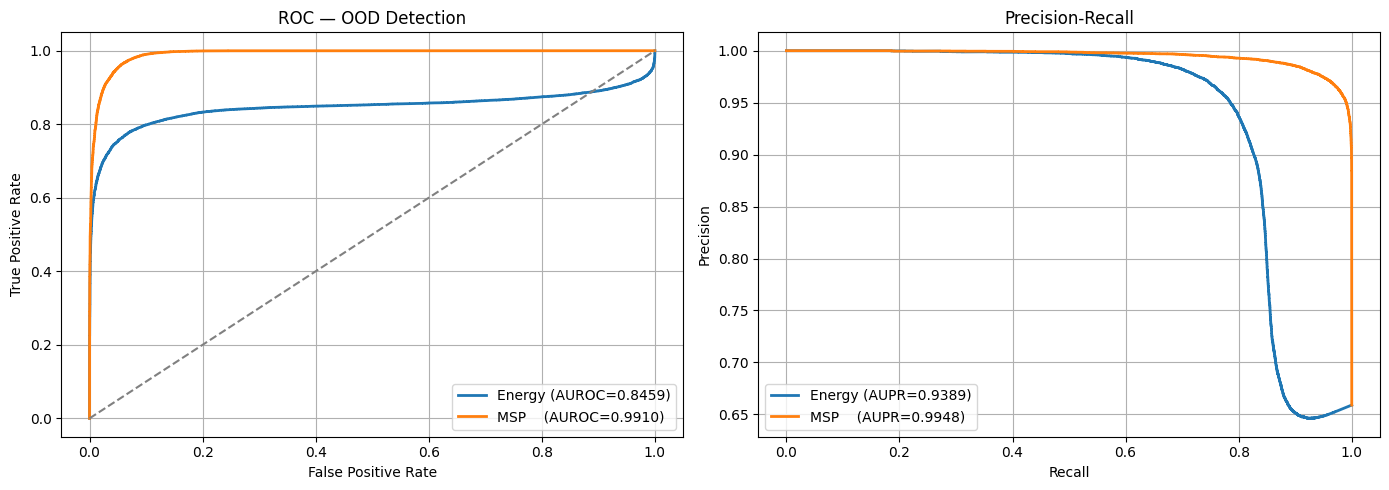

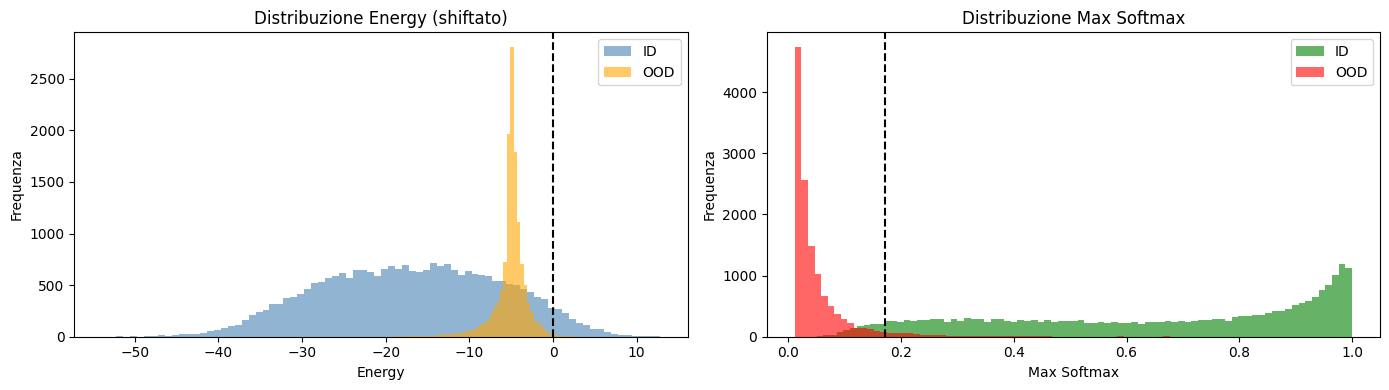

In [16]:
# Curve ROC e PR
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_e, tpr_e, label=f"Energy (AUROC={auroc_energy:.4f})", linewidth=2)
plt.plot(fpr_s, tpr_s, label=f"MSP    (AUROC={auroc_msp:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — OOD Detection")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rc_e, pr_e, label=f"Energy (AUPR={aupr_e:.4f})", linewidth=2)
plt.plot(rc_s, pr_s, label=f"MSP    (AUPR={aupr_m:.4f})", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Istogrammi Energy e MSP
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(id_energy_s,  bins=80, alpha=0.6, label="ID", color="steelblue")
axes[0].hist(ood_energy_s, bins=80, alpha=0.6, label="OOD", color="orange")
axes[0].axvline(0, color="black", linestyle="--")
axes[0].set_title("Distribuzione Energy (shiftato)")
axes[0].set_xlabel("Energy")
axes[0].set_ylabel("Frequenza")
axes[0].legend()

axes[1].hist(id_msp,  bins=80, alpha=0.6, label="ID", color="green")
axes[1].hist(ood_msp, bins=80, alpha=0.6, label="OOD", color="red")
axes[1].axvline(tau_msp, color="black", linestyle="--")
axes[1].set_title("Distribuzione Max Softmax")
axes[1].set_xlabel("Max Softmax")
axes[1].set_ylabel("Frequenza")
axes[1].legend()

plt.tight_layout()
plt.show()


# USE OF FOOD PACKAGING 

This code defines a custom dataset class to load unlabeled images from a directory structure, applying standard preprocessing transformations. It prepares the Food Packaging dataset to be used as OOD (Out-Of-Distribution) input, using the same normalization and resizing steps as the in-distribution test set (Food-101). Finally, it wraps the dataset in a DataLoader for efficient batch processing.

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Trasformazione come nel test set ID (Food-101)
ood_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset senza etichette
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for fname in files:
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(os.path.join(root, fname))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# ✅ Percorso corretto alla directory con le immagini
foodpack_path = "/kaggle/input/fooddatasert/resize_data(150)/resize_data(1~50)"

# DataLoader
foodpack_dataset = UnlabeledImageDataset(foodpack_path, transform=ood_transform)
foodpack_loader = DataLoader(foodpack_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✔️ Dataset Food Packaging caricato con {len(foodpack_dataset)} immagini.")


✔️ Dataset Food Packaging caricato con 40362 immagini.


This script evaluates the model's ability to detect out-of-distribution (OOD) data using both the Energy score and Maximum Softmax Probability (MSP). First, it computes the final classification accuracy on the in-distribution test set (Food-101). Then, it calculates energy and softmax-based scores for both ID and OOD samples (Food Packaging). Using these scores, it computes standard OOD metrics like AUROC, FPR\@95TPR, and AUPR. Finally, it visualizes performance through ROC and PR curves, and plots the distributions of the energy and softmax scores to show the separation between ID and OOD data.

Testing: 100%|██████████| 395/395 [01:34<00:00,  4.16it/s]


🧪 Final Test Accuracy (Food-101): 76.60%



📊  METRICHE OOD  (ID = Food-101,  OOD = Food Packaging)
• AUROC  (Energy)      : 0.7678
• AUROC  (Soft-max)    : 0.9130
• FPR@95TPR (Energy)   : 2.50%
• FPR@95TPR (Soft-max) : 46.31%
• AUPR-In (Energy)     : 0.7870
• AUPR-In (Soft-max)   : 0.8921


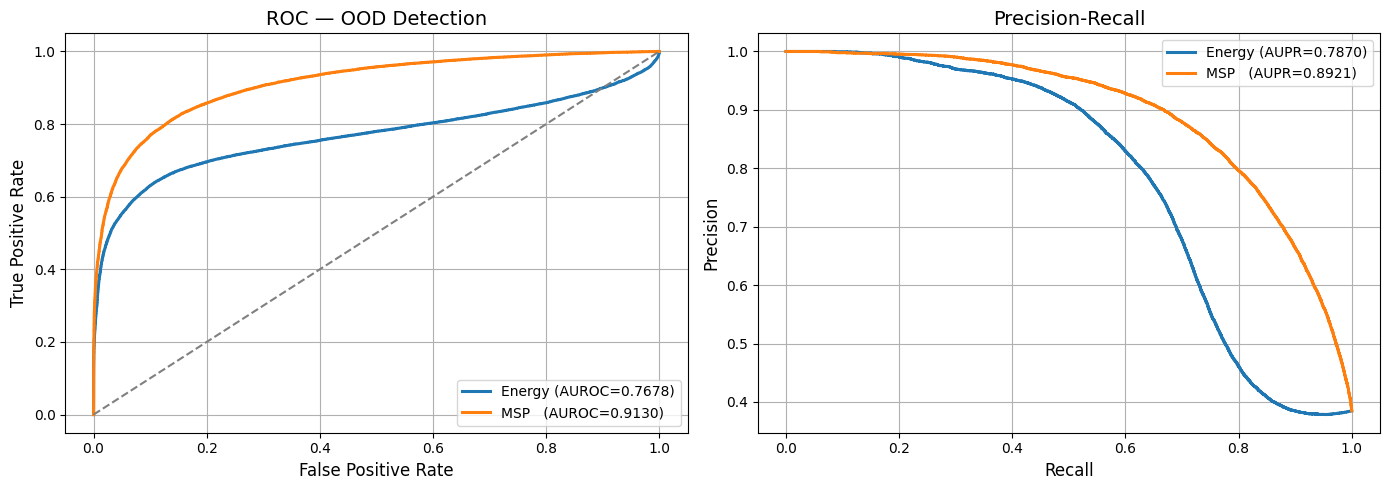

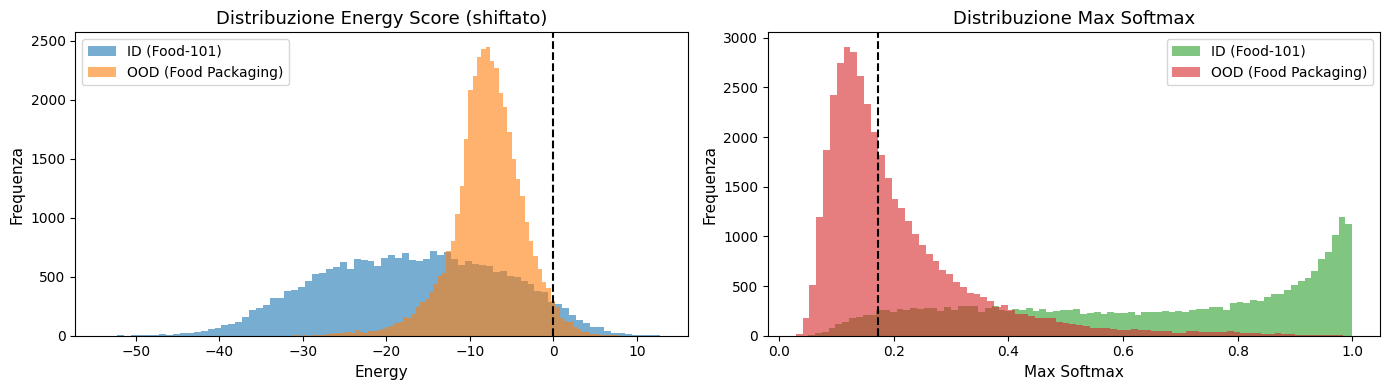

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from tqdm import tqdm
import torch

# 1. Accuracy finale sul test set ID (Food-101)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    test_loop = tqdm(test_loader, total=len(test_loader), desc="Testing")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n🧪 Final Test Accuracy (Food-101): {100 * correct / total:.2f}%")

# 2. OOD Detection — ENERGY & MSP
T = 0.2
PLOT_HIST = True

def _images_from(batch):
    return batch[0] if isinstance(batch, (list, tuple)) else batch

@torch.no_grad()
def energy_scores(loader, T):
    out = []
    for batch in loader:
        x = _images_from(batch).to(device, non_blocking=True)
        out.append((-torch.logsumexp(model(x) / T, 1)).cpu())
    return torch.cat(out).numpy()

@torch.no_grad()
def msp_scores(loader):
    out = []
    for batch in tqdm(loader, desc="MSP", leave=False):
        x = _images_from(batch).to(device, non_blocking=True)
        out.append(torch.softmax(model(x), dim=1).max(1).values.cpu())
    return torch.cat(out).numpy()

# 3. Calcolo score
id_energy  = energy_scores(test_loader, T)
ood_energy = energy_scores(foodpack_loader,  T)
id_msp     = msp_scores(test_loader)
ood_msp    = msp_scores(foodpack_loader)

# 4. m-shift & label
m            = np.percentile(id_energy, 95)
id_energy_s  = id_energy - m
ood_energy_s = ood_energy - m
energy_cat   = -np.concatenate([id_energy_s, ood_energy_s])  # più alto = ID
labels       = np.concatenate([np.ones_like(id_energy_s), np.zeros_like(ood_energy_s)])

# 5. Metriche
auroc_energy = roc_auc_score(labels, energy_cat)
auroc_msp    = roc_auc_score(labels, np.concatenate([id_msp, ood_msp]))

fpr_e, tpr_e, _ = roc_curve(labels, energy_cat)
fpr_s, tpr_s, _ = roc_curve(labels, np.concatenate([id_msp, ood_msp]))

tau_energy   = 0.0
tau_msp      = np.percentile(id_msp, 5)
fpr95_energy = (ood_energy_s > tau_energy).mean()
fpr95_msp    = (ood_msp > tau_msp).mean()

pr_e, rc_e, _ = precision_recall_curve(labels, energy_cat)
pr_s, rc_s, _ = precision_recall_curve(labels, np.concatenate([id_msp, ood_msp]))

aupr_e = average_precision_score(labels, energy_cat)
aupr_m = average_precision_score(labels, np.concatenate([id_msp, ood_msp]))

# 6. Stampa risultati
print("\n📊  METRICHE OOD  (ID = Food-101,  OOD = Food Packaging)")
print(f"• AUROC  (Energy)      : {auroc_energy:.4f}")
print(f"• AUROC  (Soft-max)    : {auroc_msp:.4f}")
print(f"• FPR@95TPR (Energy)   : {fpr95_energy*100:.2f}%")
print(f"• FPR@95TPR (Soft-max) : {fpr95_msp*100:.2f}%")
print(f"• AUPR-In (Energy)     : {aupr_e:.4f}")
print(f"• AUPR-In (Soft-max)   : {aupr_m:.4f}")

# 7. ROC & PR Curve
plt.figure(figsize=(14, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_e, tpr_e, linewidth=2.2, label=f"Energy (AUROC={auroc_energy:.4f})")
plt.plot(fpr_s, tpr_s, linewidth=2.2, label=f"MSP   (AUROC={auroc_msp:.4f})")
plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1.5)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC — OOD Detection", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# PR
plt.subplot(1, 2, 2)
plt.plot(rc_e, pr_e, linewidth=2.2, label=f"Energy (AUPR={aupr_e:.4f})")
plt.plot(rc_s, pr_s, linewidth=2.2, label=f"MSP   (AUPR={aupr_m:.4f})")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Istogrammi
if PLOT_HIST:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].hist(id_energy_s,  bins=80, alpha=0.6, label="ID (Food-101)", color="#1f77b4")
    axes[0].hist(ood_energy_s, bins=80, alpha=0.6, label="OOD (Food Packaging)", color="#ff7f0e")
    axes[0].axvline(0, color="k", ls="--", linewidth=1.5)
    axes[0].set_title("Distribuzione Energy Score (shiftato)", fontsize=13)
    axes[0].set_xlabel("Energy", fontsize=11)
    axes[0].set_ylabel("Frequenza", fontsize=11)
    axes[0].legend(fontsize=10)

    axes[1].hist(id_msp,  bins=80, alpha=0.6, label="ID (Food-101)", color="#2ca02c")
    axes[1].hist(ood_msp, bins=80, alpha=0.6, label="OOD (Food Packaging)", color="#d62728")
    axes[1].axvline(tau_msp, color="k", ls="--", linewidth=1.5)
    axes[1].set_title("Distribuzione Max Softmax", fontsize=13)
    axes[1].set_xlabel("Max Softmax", fontsize=11)
    axes[1].set_ylabel("Frequenza", fontsize=11)
    axes[1].legend(fontsize=10)

    plt.tight_layout()
    plt.show()


-------------------------------------------------------------------------------------------------------------

# IMPORT
This section imports all the necessary libraries for the project, including PyTorch for deep learning, torchvision for dataset and model utilities, and scikit-learn for data splitting. It also includes utility packages like NumPy for numerical operations, Matplotlib for plotting, and tqdm for progress bars.


In [ ]:
# Librerie base
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# Torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

# Scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit

# Altre
from tqdm.notebook import tqdm
import copy


# GLOBALS

This block sets the random seed for reproducibility, configures the computing device (CPU or GPU), defines dataset paths, and initializes several key hyperparameters for Outlier Exposure (OE) training—such as margin thresholds, loss coefficients, learning rate, early stopping, and number of epochs.

In [ ]:
# Seed e device
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device attivo: {device}")

# Parametri dataset
dataset_root = "/kaggle/input/food101/food-101"
images_root = os.path.join(dataset_root, "images")
train_txt = os.path.join(dataset_root, "meta", "train.txt")
test_txt  = os.path.join(dataset_root, "meta", "test.txt")

# Hyperparametri OE
M_IN, M_OUT     = -6.0, -0.5
LAMBDA_MAX      = 0.06
ALPHA_ID        = 0.05
WARMUP_EP       = 3
RAMP_EP         = 2
PATIENCE        = 6
TEMPERATURE     = 1.0
EPOCHS_OE       = 20
PRINT_EVERY     = 100
LR_OE_INIT      = 1e-4
WEIGHT_DECAY    = 1e-4
BATCH_SIZE      = 64


# UTILS

This section defines utility functions for handling dataset indices and computing energy-based scores. It includes a function to extract sample indices from .txt metadata files and two functions related to energy-based Outlier Exposure (OE): one to compute energy from model logits, and another that implements the energy regularization loss. This loss penalizes in-distribution samples with energy above a margin and out-of-distribution samples with energy below a threshold.

In [ ]:
# Carica indici da file .txt
def load_indices(txt_file, dataset):
    with open(txt_file, "r") as f:
        lines = f.read().splitlines()
    idxs = []
    for rel_path in lines:
        for i, (img_path, _) in enumerate(dataset.samples):
            if rel_path in img_path:
                idxs.append(i)
                break
    return idxs

# Energy score da logits
def compute_energy(logits, T=1.0):
    return -T * torch.logsumexp(logits / T, dim=1)

# Funzione di loss OE (energy-based)
def energy_regularization_loss(logits_id, logits_ood, m_in=-6.0, m_out=-1.0, lambda_energy=0.1, T=1.0):
    energy_id = compute_energy(logits_id, T)
    energy_ood = compute_energy(logits_ood, T)
    loss_id = torch.mean(torch.clamp(energy_id - m_in, min=0)**2)
    loss_ood = torch.mean(torch.clamp(m_out - energy_ood, min=0)**2)
    return lambda_energy * (loss_id + loss_ood)


# DATA

This code prepares the Food-101 dataset for training, validation, and testing. It defines two sets of image transformations: one with heavy data augmentation for training, and another simpler one for evaluation. It then loads the full dataset and uses pre-defined text files to extract train/test indices. A stratified split is performed on the training set to create a validation subset. Finally, `DataLoader`s are initialized for each subset to efficiently feed data during training and evaluation.

In [ ]:
# Trasformazioni
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(0.2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset completo
full_dataset_train = ImageFolder(images_root, transform=train_transform)
full_dataset_eval  = ImageFolder(images_root, transform=test_transform)

train_indices = load_indices(train_txt, full_dataset_train)
test_indices  = load_indices(test_txt, full_dataset_train)

# Split stratificato
val_split = 0.1
train_labels = [full_dataset_train.samples[i][1] for i in train_indices]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=42)
train_idx, val_idx = next(splitter.split(train_indices, train_labels))

# Subset
train_id = Subset(full_dataset_train, [train_indices[i] for i in train_idx])
val_id   = Subset(full_dataset_eval,  [train_indices[i] for i in val_idx])
test_id  = Subset(full_dataset_eval,  test_indices)

# Dataloader
train_loader = DataLoader(train_id, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_id,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_id,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


# NETWORK

This code defines and initializes a custom ResNet-50 model for the Food-101 classification task. It loads pretrained weights (if specified) and replaces the original fully connected layer with a new head composed of a dropout layer followed by a linear layer that outputs predictions for 101 food classes. The model is then moved to the specified computation device (CPU or GPU).

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

def build_resnet50_food101(
        num_classes=101,
        pretrained=True,
        dropout_p=0.3,
        device=None
) -> nn.Module:
    weights = ResNet50_Weights.DEFAULT if pretrained else None
    model = resnet50(weights=weights)

    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(model.fc.in_features, num_classes)
    )

    return model.to(device) if device else model

model = build_resnet50_food101(device=device)
print(model)


# TRAIN OE

This code implements the full fine-tuning process of the ResNet-50 model using Outlier Exposure (OE) and an energy-based regularization strategy. It defines an Adam optimizer and a cosine annealing scheduler to adjust the learning rate across epochs. During training, the model minimizes a loss composed of a cross-entropy term on in-distribution (ID) samples and an energy-based term that encourages the model to assign lower energy to ID and higher energy to OOD (out-of-distribution) samples. A dynamic λ is used to gradually increase the contribution of the OE loss (after a warm-up and ramp-up phase), while label smoothing is progressively reduced. After each epoch, the model is evaluated on a validation set, and early stopping is applied based on validation loss improvements. The best model weights are saved during training.

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Ottimizzatore e scheduler
optimizer = optim.Adam(model.parameters(), lr=LR_OE_INIT, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Loss functions
label_smooth = 0.1
criterion_id  = nn.CrossEntropyLoss(label_smoothing=label_smooth)
criterion_val = nn.CrossEntropyLoss()

# Energy function (per comodità)
def energy(logits, T=TEMPERATURE):
    return -T * torch.logsumexp(logits / T, dim=1)

# Stato per early stopping
best_val_loss = float("inf")
best_wts      = copy.deepcopy(model.state_dict())
no_improve    = 0

for epoch in range(EPOCHS_OE):
    # Calcolo λ dinamico (warmup + ramp-up)
    if epoch < WARMUP_EP:
        lam = 0.0
    elif epoch < WARMUP_EP + RAMP_EP:
        lam = LAMBDA_MAX * (epoch - WARMUP_EP + 1) / RAMP_EP
    else:
        lam = LAMBDA_MAX

    # Aggiorna label smoothing dopo warmup+ramp
    if epoch >= WARMUP_EP + RAMP_EP and label_smooth > 0:
        label_smooth = max(0.0, label_smooth - 0.05)
        criterion_id.label_smoothing = label_smooth

    print(f"\nEpoch {epoch+1}/{EPOCHS_OE} | λ={lam:.3f} | LR={optimizer.param_groups[0]['lr']:.2e} | LS={label_smooth:.2f}")

    # Train
    model.train()
    ood_iter = iter(svhn_loader)
    run_gap = correct = total = 0

    for i, (x_id, y_id) in enumerate(train_loader):
        try:
            x_ood = next(ood_iter)
        except StopIteration:
            ood_iter = iter(svhn_loader)
            x_ood = next(ood_iter)

        x_id, y_id, x_ood = x_id.to(device), y_id.to(device), x_ood.to(device)

        # Forward pass
        logits_id  = model(x_id)
        logits_ood = model(x_ood)

        # CE + OE loss
        loss_ce = criterion_id(logits_id, y_id)
        e_id  = energy(logits_id)
        e_ood = energy(logits_ood)
        gap   = (e_ood.mean() - e_id.mean()).item()

        loss_id  = torch.clamp(e_id - M_IN, min=0).pow(2).mean()
        loss_ood = torch.clamp(M_OUT - e_ood, min=0).pow(2).mean()
        loss_oe  = lam * (loss_ood + ALPHA_ID * loss_id)
        loss = loss_ce + loss_oe

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistiche
        run_gap += gap
        correct += (logits_id.argmax(1) == y_id).sum().item()
        total   += y_id.size(0)

        if (i+1) % PRINT_EVERY == 0 or (i+1) == len(train_loader):
            print(f"batch {i+1:4d} | gap={gap:4.2f} | CE={loss_ce.item():.3f} | OE={loss_oe.item():.3f}")

    train_acc = 100 * correct / total
    print(f"Train accuracy: {train_acc:.2f}% — mean gap: {run_gap/len(train_loader):.2f}")

    # Validazione
    model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            out = model(x.to(device))
            val_loss  += criterion_val(out, y.to(device)).item()
            val_correct += (out.argmax(1) == y.to(device)).sum().item()
            val_total   += y.size(0)

    val_loss /= len(val_loader)
    val_acc   = 100 * val_correct / val_total
    print(f"Val loss: {val_loss:.4f} — accuracy: {val_acc:.2f}%")

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, "best_model_weights.pth")
        no_improve = 0
        print("Model salvato.")
    else:
        no_improve += 1
        print(f"Nessun miglioramento ({no_improve}/{PATIENCE})")
        if no_improve >= PATIENCE:
            print("Early stopping attivato.")
            break

    scheduler.step()


# EVALUATION
This final evaluation block loads the best model weights obtained during training and recalibrates the BatchNorm statistics using the training set. It then computes the energy scores and maximum softmax probabilities (MSP) for both in-distribution (Food-101) and out-of-distribution (SVHN) samples. After shifting the energy scores using the 95th percentile of the ID distribution, the script evaluates the model's OOD detection performance using standard metrics: AUROC, FPR\@95TPR, and AUPR. Results are reported for both the energy-based and softmax-based methods, providing a comprehensive assessment of the model's ability to distinguish ID from OOD data.


In [ ]:
# Carica i migliori pesi e ricalibra BatchNorm
model.load_state_dict(best_wts)
model.train()
with torch.no_grad():
    for x, _ in DataLoader(train_id, batch_size=256, shuffle=False):
        _ = model(x.to(device))
model.eval()
print("Pesi migliori caricati. BatchNorm ricalibrato.")
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

@torch.no_grad()
def energy_scores(loader, T=TEMPERATURE):
    model.eval()
    scores = []
    for x in loader:
        x = x.to(device)
        logits = model(x)
        scores.append(compute_energy(logits, T).cpu())
    return torch.cat(scores).numpy()

@torch.no_grad()
def msp_scores(loader):
    model.eval()
    scores = []
    for x in loader:
        x = x.to(device)
        logits = model(x)
        softmax = torch.softmax(logits, dim=1)
        scores.append(softmax.max(1).values.cpu())
    return torch.cat(scores).numpy()

# Score ID e OOD
id_energy  = energy_scores(test_loader)
ood_energy = energy_scores(svhn_loader)
id_msp     = msp_scores(test_loader)
ood_msp    = msp_scores(svhn_loader)

# Energy shift
m = np.percentile(id_energy, 95)
id_energy_s  = id_energy - m
ood_energy_s = ood_energy - m
energy_cat   = -np.concatenate([id_energy_s, ood_energy_s])
labels       = np.concatenate([np.ones_like(id_energy_s), np.zeros_like(ood_energy_s)])

# MSP concat
msp_cat = np.concatenate([id_msp, ood_msp])

# AUROC e FPR@95
auroc_energy = roc_auc_score(labels, energy_cat)
auroc_msp    = roc_auc_score(labels, msp_cat)

tau_energy   = 0.0
tau_msp      = np.percentile(id_msp, 5)
fpr95_energy = (ood_energy_s > tau_energy).mean()
fpr95_msp    = (ood_msp > tau_msp).mean()

# AUPR
pr_e, rc_e, _ = precision_recall_curve(labels, energy_cat)
pr_s, rc_s, _ = precision_recall_curve(labels, msp_cat)
aupr_e = average_precision_score(labels, energy_cat)
aupr_m = average_precision_score(labels, msp_cat)

# Risultati
print("\nValutazione OOD (ID = Food-101, OOD = SVHN)")
print(f"AUROC        (Energy):   {auroc_energy:.4f}")
print(f"AUROC        (Softmax):  {auroc_msp:.4f}")
print(f"FPR@95TPR    (Energy):   {fpr95_energy*100:.2f}%")
print(f"FPR@95TPR    (Softmax):  {fpr95_msp*100:.2f}%")
print(f"AUPR (in)    (Energy):   {aupr_e:.4f}")
print(f"AUPR (in)    (Softmax):  {aupr_m:.4f}")


In [ ]:
# ROC + PR + Histograms
plt.figure(figsize=(14, 5))

# ROC
fpr_e, tpr_e, _ = roc_curve(labels, energy_cat)
fpr_s, tpr_s, _ = roc_curve(labels, msp_cat)

plt.subplot(1, 2, 1)
plt.plot(fpr_e, tpr_e, label=f"Energy (AUROC = {auroc_energy:.4f})", linewidth=2)
plt.plot(fpr_s, tpr_s, label=f"Softmax (AUROC = {auroc_msp:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# PR
plt.subplot(1, 2, 2)
plt.plot(rc_e, pr_e, label=f"Energy (AUPR = {aupr_e:.4f})", linewidth=2)
plt.plot(rc_s, pr_s, label=f"Softmax (AUPR = {aupr_m:.4f})", linewidth=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Energy histogram
axes[0].hist(id_energy_s,  bins=80, alpha=0.6, label="ID", color="steelblue")
axes[0].hist(ood_energy_s, bins=80, alpha=0.6, label="OOD", color="orange")
axes[0].axvline(0, color="black", linestyle="--")
axes[0].set_title("Distribuzione Energy Score (shiftato)")
axes[0].set_xlabel("Energy")
axes[0].set_ylabel("Frequenza")
axes[0].legend()

# MSP histogram
axes[1].hist(id_msp,  bins=80, alpha=0.6, label="ID", color="green")
axes[1].hist(ood_msp, bins=80, alpha=0.6, label="OOD", color="red")
axes[1].axvline(tau_msp, color="black", linestyle="--")
axes[1].set_title("Distribuzione Max Softmax")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequenza")
axes[1].legend()

plt.tight_layout()
plt.show()


-------------------------------------------------------